# Assignment 1 - Scott Wilkinson (V00887986) 

## Question 2: SGD Regression

A notebook which uses a SGD regression model to predict the time of merger of simulated galaxies from IllustrisTNG based on their non-parametric morphology data.

First, we must import the necessary Python packages.

In [1]:
# importing packages used in notebook
import numpy as np
import matplotlib.pyplot as plt
import pymysql, os

In [2]:
# BTW if you need a package installed, you can use the following

#import os
#os.system('pip install pymysql')

## Importing Morphology Data

In [3]:
#Query SQL for morphology data
# connects to database
db = pymysql.connect(host = 'lauca.phys.uvic.ca', db = 'sdss', user = 'swilkinson', passwd = '123Sdss!@#')
# select morphology params that have unflagged morphology fits
x = 'SELECT  dbID, asymmetry, shape_asymmetry, gini_m20_merger, concentration, outer_asymmetry, deviation, multimode, intensity \
    FROM simCFIS_morph\
    WHERE flag_morph = 0\
    AND asymmetry > -1'
c = db.cursor()
c.execute(x)
db_data = c.fetchall()
c.close()
db.close()

# save names as a string
names_morph = np.array(db_data, dtype = str).T[0]

# save rest of data as floats
morph = np.array(db_data, dtype = float).T[1:]

print(morph.shape)

(8, 219933)


# Merger Sample Selection

## Selecting a Sample of Pre-Merger Galaxies

Here is the reasoning behind my selection cuts:

1.  snap >= 50 requires z<1 in the simulation (ie. enough time for galaxies to form, evolve and begin to merge)
2. rsep > 0 requires there to be two merging galaxies that are not on top of each other yet
3. mass ratio > 0.1, the merger will be significant when it occurs
4. Flaguntilmerger = 1 ensures the merger is true and not a projection effect that confuses the `subfind` code (see Hani et al. 2020, Rodriguez-Gomez et al. 2015)
5. Tuntilmerger < 0.5 ensures the merger will happen soon (< 500 Myr) and the galaxies have begun to gravitationally interact
6. Tpostmerger > 0.5 ensures no recent has occurred that would cause the disturbed morphology

In [4]:
#Query MySQL with reasoning described above
db = pymysql.connect(host = 'lauca.phys.uvic.ca', db = 'IllustrisTNG100_1', user = 'swilkinson', passwd = '123Sdss!@#')
x ='SELECT e.DB_ID, e.Mstar, e.Tuntilmerger, e.MassRatiountilmerger\
    FROM Environment e \
    WHERE snapNum>=50\
    AND rsep>0 \
    AND MassRatiountilmerger>=0.1\
    AND Flaguntilmerger = 1\
    AND Tuntilmerger < 0.5\
    AND Tpostmerger > 0.5'
c = db.cursor()
c.execute(x)
db_data = c.fetchall()
c.close()
db.close()

names_db_pre = np.array(db_data, dtype = str).T[0]
Mstar_pre = np.array(db_data, dtype = float).T[1]
Tum_pre = np.array(db_data, dtype = float).T[2]
mu_pre = np.array(db_data, dtype = float).T[3]

# give time before merger a negative value
Tum_pre *= -1

# differentiate pre-merger galaxies that merge within the next snapshot from post-merger galaxies
#   that have merged within the last snap shot by adding / subtracting 0.1Gyr (approx the middle of a snapshot)
Tum_pre[Tum_pre == 0] = -0.05

# add 0 to match formatting with morphology catalogue
names_db_pre = np.array(['0'+n for n in names_db_pre])

print('There are {} pre-merger galaxies.'.format(len(names_db_pre)))

# match the two catalogues
match, idx_morph_pre, idx_pre = np.intersect1d(names_morph, names_db_pre, return_indices = True)

print('There are {} pre-merger galaxies with flag-free morphology data.'.format(len(names_db_pre[idx_pre])))

There are 7322 pre-merger galaxies.
There are 2886 pre-merger galaxies with flag-free morphology data.


## Selecting a Sample of Post-Merger Galaxies

Here is the reasoning behind my selection cuts:

1. snap >= 50 requires z<1 in the simulation (ie. enough time for galaxies to form, evolve and begin to merge)
2. mass ratio > 0.1, the merger that occurred was significant
3. Flagpostmerger = 1 ensures the merger is true and not a projection effect that confuses the `subfind` code
4. Tpostmerger < 0.5 requires a merger to have occurred in the last 500 Myr
5. rsep > 25 and Tuntilmerger < 0.5 requires there to be no nearby galaxies about to cause another merger in the next 500 Myr

In [5]:
#Query MySQL with the reasoning listed above
db = pymysql.connect(host = 'lauca.phys.uvic.ca', db = 'IllustrisTNG100_1', user = 'swilkinson', passwd = '123Sdss!@#')
x ='SELECT e.DB_ID, e.Mstar, e.Tpostmerger, e.MassRatio\
    FROM Environment e \
    WHERE snapNum>=50\
    AND MassRatio>=0.1\
    AND Flagpostmerger = 1\
    AND Tpostmerger < 0.5\
    AND rsep>25\
    AND Tuntilmerger > 0.5'
c = db.cursor()
c.execute(x)
db_data = c.fetchall()
c.close()
db.close()

names_db_post = np.array(db_data, dtype = str).T[0]
Mstar_post = np.array(db_data, dtype = float).T[1]
Tpm_post = np.array(db_data, dtype = float).T[2]
mu_post = np.array(db_data, dtype = float).T[3]

# add 0 to match formatting with morphology catalogue
names_db_post = np.array(['0'+n for n in names_db_post])

# differentiate pre-merger galaxies that merge within the next snapshot from post-merger galaxies
#   that have merged within the last snap shot by adding / subtracting 0.1Gyr (approx the middle of a snapshot)
Tpm_post[Tpm_post == 0] = 0.05

print('There are {} post-merger galaxies.'.format(len(names_db_post)))

# match with morphology catalogue
match, idx_morph_post, idx_post = np.intersect1d(names_morph, names_db_post, return_indices = True)

print('There are {} post-merger galaxies with flag-free morphology data.'.format(len(names_db_post[idx_post])))

names_db_post = names_db_post[idx_post]
Mstar_post = Mstar_post[idx_post]
Tpm_post = Tpm_post[idx_post]
mu_post = mu_post[idx_post]

There are 5153 post-merger galaxies.
There are 3456 post-merger galaxies with flag-free morphology data.


# Preparing Data for Model

In [6]:
# list of all merging galaxies
names_mergers = np.array(list(names_db_pre) + list(names_db_post))
T_merger = np.array(list(Tum_pre) + list(Tpm_post))
mu = np.array(list(mu_pre) + list(mu_post))
mass = np.array(list(Mstar_pre) + list(Mstar_post))

# match catalogues
match, idx_morph, idx_merge = np.intersect1d(names_morph, names_mergers, return_indices = True)

T_merger = T_merger[idx_merge]
mu = mu[idx_merge]
mass = mass[idx_merge]
morph = morph[:,idx_morph]

In [7]:
# shape of output
print(morph.shape)

(8, 6342)


In [8]:
# shape of output
print(T_merger.shape)

(6342,)


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [10]:
# create training and validation sets (75/25 split)
input_tr,input_va,target_tr, target_va = train_test_split(morph.T, T_merger,test_size=0.25, shuffle = True)
#input_tr,input_va,target_tr, target_va = train_test_split(morph.T, mu, test_size=0.25, shuffle = True)
#input_tr,input_va,target_tr, target_va = train_test_split(morph.T, mass,test_size=0.25, shuffle = True)

In [11]:
### normalizing inputs

# fit on training set
scaler = StandardScaler().fit(input_tr)  

# normalize training
input_tr_norm= scaler.transform(input_tr) 

# normalize validation with same scaler & fit
input_va_norm= scaler.transform(input_va)

# Stochastic Gradient Descent

In [25]:
from sklearn import linear_model

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


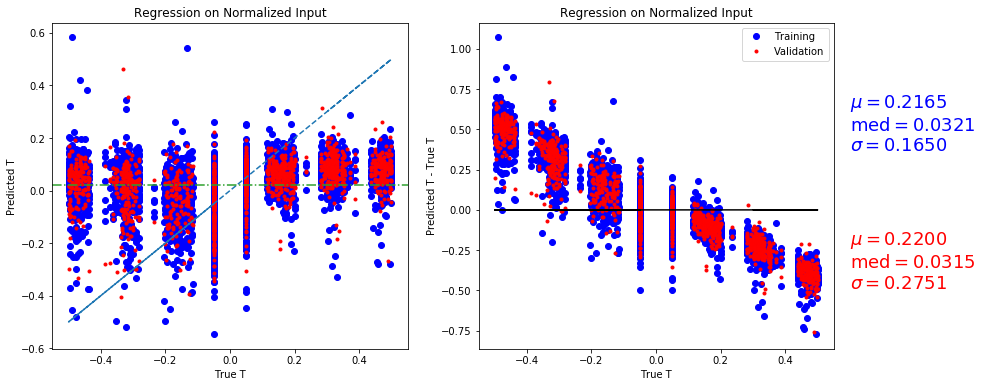

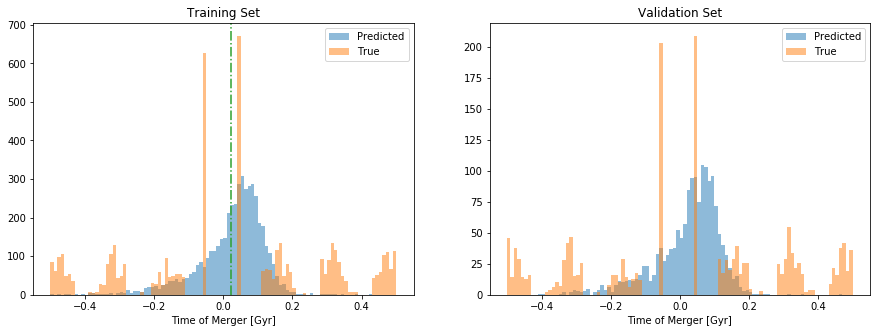

In [13]:
# define hyper parameters
SGD = linear_model.SGDRegressor()

# fit the model with training set
SGD.fit(input_tr_norm,target_tr)  

#'predictions for training and validation sets'
target_tr_pred= SGD.predict(input_tr_norm)  
target_va_pred= SGD.predict(input_va_norm)

fig, [ax1, ax2] = plt.subplots(1,2,figsize = (14,6))

ax1.plot(target_tr,target_tr_pred, 'ob')
ax1.plot(target_va,target_va_pred, '.r')
ax1.plot(target_tr, target_tr, '--')
ax1.axhline(np.mean(target_tr), ls = '-.', color = 'tab:green')
ax1.set_xlabel('True T')
ax1.set_ylabel('Predicted T')
ax1.set_title('Regression on Normalized Input')

ax2.plot(target_tr,target_tr_pred-target_tr,'o', color = 'blue')
ax2.plot(target_va,target_va_pred-target_va,'.', color = 'red')
ax2.plot(target_tr,np.zeros(len(target_tr)), '-k')
ax2.set_xlabel('True T')
ax2.set_ylabel('Predicted T - True T')
ax2.set_title('Regression on Normalized Input')
ax2.legend(['Training', 'Validation'])

mu = np.mean(np.abs(target_tr-target_tr_pred))
median = np.median(target_tr-target_tr_pred)
sigma = np.std(np.abs(target_tr-target_tr_pred))

muv = np.mean(np.abs(target_va-target_va_pred))
medianv = np.median(target_va-target_va_pred)
sigmav = np.std(target_va-target_va_pred)

textstr = '$\mu=%.4f$\n$\mathrm{med}=%.4f$\n$\sigma=%.4f$'%(mu, median, sigma)
textstrv = '$\mu=%.4f$\n$\mathrm{med}=%.4f$\n$\sigma=%.4f$'%(muv, medianv, sigmav)

ax2.text(1.2*max(target_tr),0.5*max(target_va-target_va_pred),textstr, color='b',fontsize=18)
ax2.text(1.2*max(target_tr),0.6*min(target_va-target_va_pred),textstrv, color='r',fontsize=18)

plt.show()

fig, [ax1, ax2] = plt.subplots(1,2,figsize = (15,5))

ax1.hist(target_tr_pred, bins = 100, range = [-0.5,0.5], alpha = 0.5, label = 'Predicted')
ax1.hist(target_tr, bins = 100, range = [-0.5,0.5], alpha = 0.5, label = 'True')
ax1.set_title('Training Set')
ax1.set_xlabel('Time of Merger [Gyr]')
ax1.axvline(np.mean(target_tr), ls = '-.', color = 'tab:green')
ax1.legend(fancybox = True)

ax2.hist(target_va_pred, bins = 100, range = [-0.5,0.5], alpha = 0.5, label = 'Predicted')
ax2.hist(target_va, bins = 100, range = [-0.5,0.5], alpha = 0.5, label = 'True')
ax2.set_title('Validation Set')
ax2.set_xlabel('Time of Merger [Gyr]')
ax2.legend(fancybox = True)

plt.show()

The SGD regressor performs even worse than the KNN regressor. It seems to even more dramatrically regress towards the mean of the target distribution (represented in plots on the left by a green dashed line). The data is clearly not appropriate to be modelled with a linear model. I am not going to spend any more time on this and will directly switch to another data set.

Changing the normalization to MinMaxScaler decreased the quality of results further.

In [22]:
#asymmetry, shape_asymmetry, gini_m20_merger, concentration, outer_asymmetry, deviation, multimode, intensity
SGD.coef_

array([-28804874.08602254, -74748136.62724568,  25279051.30669655,
        53250514.24184413,    101363.95231968,  -4874466.59110229,
          579073.04293321])

# Switching data set: let's try on real galaxies

The new data set is the same morphology parameters but for real galaxies, imaged using deep and high resolution CFIS imaging. 

In this case, we take all galaxies (not just mergers and try to predict their concentration based on other non-parametric morphologies.

In [16]:
#Query SQL for morphology data
# connects to database
db = pymysql.connect(host = 'lauca.phys.uvic.ca', db = 'sdss', user = 'swilkinson', passwd = '123Sdss!@#')
x = 'SELECT  s.objID, asymmetry, shape_asymmetry, gini, m20, sersic_n, r20, r80, concentration, total_mass_med\
    FROM dr7_cfis_statmorph_newmask s, dr7_uberuber u\
    WHERE u.objID = s.objID\
    AND flag_morph = 0\
    AND flag_sersic = 0\
    AND asymmetry > -1\
    AND total_sfr_med>-5\
    AND total_mass_med > 7'
c = db.cursor()
c.execute(x)
db_data = c.fetchall()
c.close()
db.close()

# save names as a string
names_morph = np.array(db_data, dtype = str).T[0]

# save rest of data as floats (-1 discludes sfr)
morph = np.array(db_data, dtype = float).T[1:-1]

# potential target
sfr = np.array(db_data, dtype = float).T[-1:]

print(morph.shape)
print(sfr.shape)

(8, 137346)
(1, 137346)


In [17]:
#input_tr,input_va,target_tr, target_va = train_test_split(morph.T, sfr.T,test_size=0.25, shuffle = True)

# splitting data into training (75%) and validation sets (25%)
input_tr,input_va,target_tr, target_va = train_test_split(morph[:-1].T, morph[-1].T,test_size=0.25, shuffle = True)
#                                                   # disclude Conc.   # conc. as target

### normalizing inputs

# fit on training set
scaler = StandardScaler().fit(input_tr)  

# normalize training
input_tr_norm= scaler.transform(input_tr)

# normalize validation with same scaler & fit
input_va_norm= scaler.transform(input_va)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


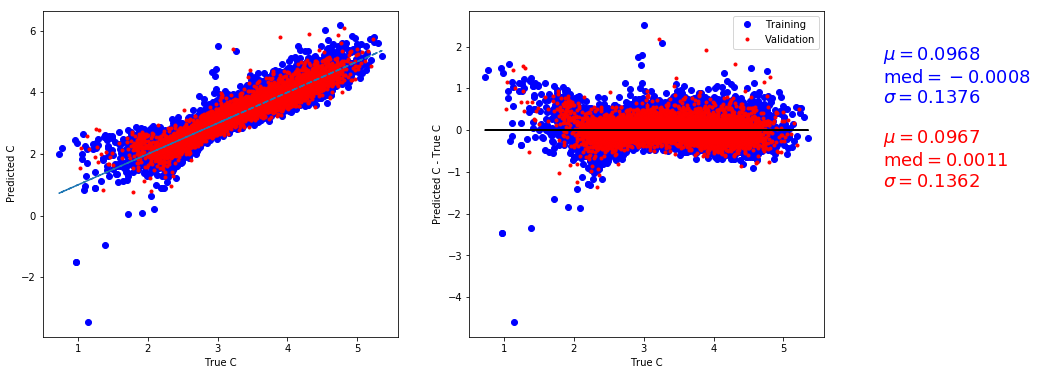

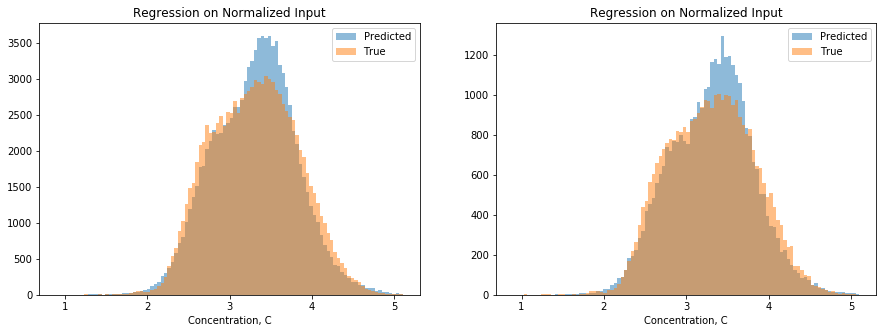

In [18]:
# define hyper parameters
SGD = linear_model.SGDRegressor()

# fit the model with training set
SGD.fit(input_tr_norm,target_tr)  

#'predictions for training and validation sets'
target_tr_pred= SGD.predict(input_tr_norm)  
target_va_pred= SGD.predict(input_va_norm)

fig, [ax1, ax2] = plt.subplots(1,2,figsize = (14,6))

ax1.plot(target_tr,target_tr_pred, 'ob')
ax1.plot(target_va,target_va_pred, '.r')
ax1.plot(target_tr, target_tr, '--')
ax1.set_xlabel('True C')
ax1.set_ylabel('Predicted C')
ax1.set_title('Regression on Normalized Input')

ax2.plot(target_tr,target_tr_pred-target_tr,'o', color = 'blue')
ax2.plot(target_va,target_va_pred-target_va,'.', color = 'red')
ax2.plot(target_tr,np.zeros(len(target_tr)), '-k')
ax2.set_xlabel('True C')
ax2.set_ylabel('Predicted C - True C')
ax2.legend(['Training', 'Validation'])
ax2.set_title('Regression on Normalized Input')

mu = np.mean(np.abs(target_tr-target_tr_pred))
median = np.median(target_tr-target_tr_pred)
sigma = np.std(target_tr-target_tr_pred)

muv = np.mean(np.abs(target_va-target_va_pred))
medianv = np.median(target_va-target_va_pred)
sigmav = np.std(target_va-target_va_pred)

textstr = '$\mu=%.4f$\n$\mathrm{med}=%.4f$\n$\sigma=%.4f$'%(mu, median, sigma)
textstrv = '$\mu=%.4f$\n$\mathrm{med}=%.4f$\n$\sigma=%.4f$'%(muv, medianv, sigmav)

ax2.text(1.2*max(target_tr),0.5*max(target_va-target_va_pred),textstr, color='b',fontsize=18)
ax2.text(1.2*max(target_tr),0.6*min(target_va-target_va_pred),textstrv, color='r',fontsize=18)

plt.show()

fig, [ax1, ax2] = plt.subplots(1,2,figsize = (15,5))

ax1.hist(target_tr_pred, bins = 100, range = [0.9,5.1], alpha = 0.5, label = 'Predicted')
ax1.hist(target_tr, bins = 100, range = [0.9,5.1], alpha = 0.5, label = 'True')
ax1.set_title('Training Set')
ax1.set_xlabel('Concentration, C')
ax1.legend(fancybox = True)

ax2.hist(target_va_pred, bins = 100, range = [0.9,5.1], alpha = 0.5, label = 'Predicted')
ax2.hist(target_va, bins = 100, range = [0.9,5.1], alpha = 0.5, label = 'True')
ax2.set_title('Validation Set')
ax2.set_xlabel('Concentration, C')
ax2.legend(fancybox = True)

plt.show()

Compared to the KNN, the SGD regressor does not perform as well, especially at low values of concentration where several extreme outliers are seen. Observing the distributions of the predictions shows that there is a tendency towards predicting typical values closer to the mean of the target distribution.

In [19]:
# asymmetry, shape_asymmetry, gini, m20, sersic_n, r20, r80
SGD.coef_

array([-0.0039093 ,  0.00214806,  0.15531984, -0.1068543 ,  0.05869986,
       -0.48613928,  0.49054134])

The two largest coeffecients are $r_{20}$ and $r_{80}$, the radii of circular apertures containing 20% and 80% of the total light of the galaxy, respectively. This comes directly from the definition of concentration: $$C = 5 \text{log}(\frac{r_{80}}{r_{20}})$$

Hence, concentration is strongly correlated with $r_{80}$ and anti-correlated with $r_{20}$.

The next largest coefficients are attributed to Gini and M20. This makes a lot of sense: the Gini statistic was originally used to describe wealth inequality -- if a small number of people hold all the wealth, Gini is high, if wealth is equally distributed across the population, Gini is 0 -- and can be used to describe the distribution of light in a galaxy. Galaxies with higher concentration have more light in a small number of pixels in the centre and thus, Gini is well correlated with concentration. M20 on the other hand, measures the spacial variance of the brighted 20% of pixels in the galaxies and thus is anti-correlated with highly concentrated galaxies.

## Let's see what happens if we don't normalize...

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


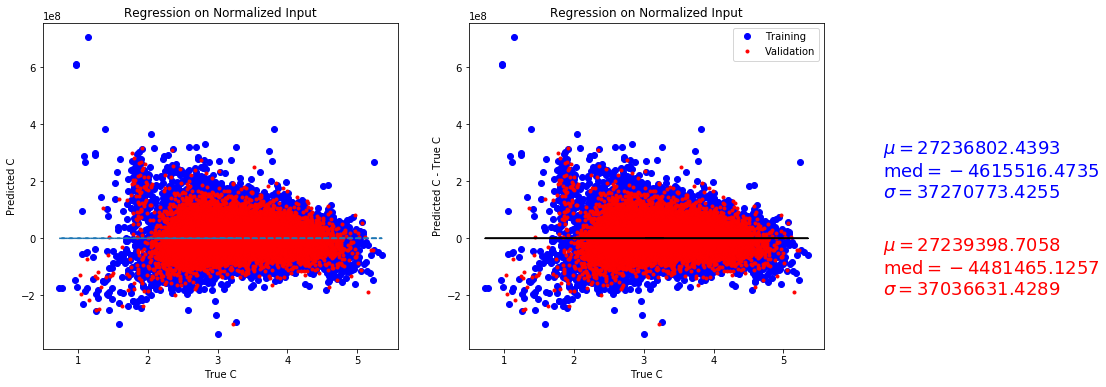

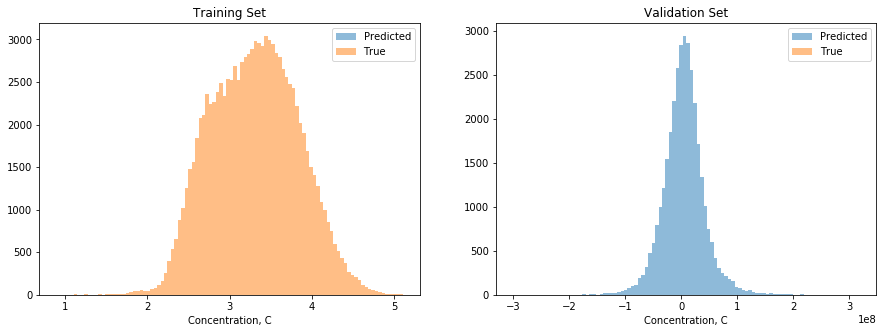

In [26]:
# define hyper parameters
SGD = linear_model.SGDRegressor()

# fit the model with training set
SGD.fit(input_tr,target_tr)  

#'predictions for training and validation sets'
target_tr_pred= SGD.predict(input_tr)  
target_va_pred= SGD.predict(input_va)

fig, [ax1, ax2] = plt.subplots(1,2,figsize = (14,6))

ax1.plot(target_tr,target_tr_pred, 'ob')
ax1.plot(target_va,target_va_pred, '.r')
ax1.plot(target_tr, target_tr, '--')
ax1.set_xlabel('True C')
ax1.set_ylabel('Predicted C')
ax1.set_title('Regression on Normalized Input')

ax2.plot(target_tr,target_tr_pred-target_tr,'o', color = 'blue')
ax2.plot(target_va,target_va_pred-target_va,'.', color = 'red')
ax2.plot(target_tr,np.zeros(len(target_tr)), '-k')
ax2.set_xlabel('True C')
ax2.set_ylabel('Predicted C - True C')
ax2.legend(['Training', 'Validation'])
ax2.set_title('Regression on Normalized Input')

mu = np.mean(np.abs(target_tr-target_tr_pred))
median = np.median(target_tr-target_tr_pred)
sigma = np.std(target_tr-target_tr_pred)

muv = np.mean(np.abs(target_va-target_va_pred))
medianv = np.median(target_va-target_va_pred)
sigmav = np.std(target_va-target_va_pred)

textstr = '$\mu=%.4f$\n$\mathrm{med}=%.4f$\n$\sigma=%.4f$'%(mu, median, sigma)
textstrv = '$\mu=%.4f$\n$\mathrm{med}=%.4f$\n$\sigma=%.4f$'%(muv, medianv, sigmav)

ax2.text(1.2*max(target_tr),0.5*max(target_va-target_va_pred),textstr, color='b',fontsize=18)
ax2.text(1.2*max(target_tr),0.6*min(target_va-target_va_pred),textstrv, color='r',fontsize=18)

plt.show()

fig, [ax1, ax2] = plt.subplots(1,2,figsize = (15,5))

ax1.hist(target_tr_pred, bins = 100, range = [0.9,5.1], alpha = 0.5, label = 'Predicted')
ax1.hist(target_tr, bins = 100, range = [0.9,5.1], alpha = 0.5, label = 'True')
ax1.set_title('Training Set')
ax1.set_xlabel('Concentration, C')
ax1.legend(fancybox = True)

ax2.hist(target_va_pred, bins = 100, alpha = 0.5, label = 'Predicted')
ax2.hist(target_va, bins = 100, alpha = 0.5, label = 'True')
ax2.set_title('Validation Set')
ax2.set_xlabel('Concentration, C')
ax2.legend(fancybox = True)

plt.show()

In the case of the SGD regressor, normalizing your inputs is absolutely vital. When inputs are not normalized the model predicts values of concentration millions of times larger than it should.

In [23]:
# asymmetry, shape_asymmetry, gini, m20, sersic_n, r20, r80
SGD.coef_

array([-28804874.08602254, -74748136.62724568,  25279051.30669655,
        53250514.24184413,    101363.95231968,  -4874466.59110229,
          579073.04293321])

The coefficients are much larger than in the normalized case.